In [5]:
# 导入pandas并且更名为pd。
import pandas as pd
# 从互联网读取titanic数据。
titanic = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt')

# 分离数据特征与预测目标。
y = titanic['survived']

X = titanic.drop(['row.names', 'name', 'survived'], axis = 1)

# 对对缺失数据进行填充。
X['age'].fillna(X['age'].mean(), inplace=True)
X.fillna('UNKNOWN', inplace=True)

# 分割数据，依然采样25%用于测试。
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)
print (X_train.head())
# 类别型特征向量化。
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
X_train = vec.fit_transform(X_train.to_dict(orient='record'))
X_test = vec.transform(X_test.to_dict(orient='record'))

# 输出处理后特征向量的维度。
print (len(vec.feature_names_))


     pclass        age     embarked                      home.dest     room  \
1086    3rd  31.194181      UNKNOWN                        UNKNOWN  UNKNOWN   
12      1st  31.194181    Cherbourg                  Paris, France     B-35   
1036    3rd  31.194181      UNKNOWN                        UNKNOWN  UNKNOWN   
833     3rd  32.000000  Southampton  Foresvik, Norway Portland, ND  UNKNOWN   
1108    3rd  31.194181      UNKNOWN                        UNKNOWN  UNKNOWN   

            ticket     boat     sex  
1086       UNKNOWN  UNKNOWN    male  
12    17477 L69 6s        9  female  
1036       UNKNOWN  UNKNOWN    male  
833        UNKNOWN  UNKNOWN    male  
1108       UNKNOWN  UNKNOWN    male  
474


In [6]:
# 使用决策树模型依靠所有特征进行预测，并作性能评估。
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)
dt.score(X_test, y_test)


0.82066869300911849

In [7]:
# 从sklearn导入特征筛选器。
from sklearn import feature_selection
# 筛选前20%的特征，使用相同配置的决策树模型进行预测，并且评估性能。
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=20)
X_train_fs = fs.fit_transform(X_train, y_train)
dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
dt.score(X_test_fs, y_test)


0.82066869300911849

In [8]:
# 通过交叉验证（下一节将详细介绍）的方法，按照固定间隔的百分比筛选特征，并作图展示性能随特征筛选比例的变化。
from sklearn.cross_validation import cross_val_score
import numpy as np

percentiles = range(1, 100, 2)
results = []

for i in percentiles:
    fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile = i)
    X_train_fs = fs.fit_transform(X_train, y_train)
    scores = cross_val_score(dt, X_train_fs, y_train, cv=5)
    results = np.append(results, scores.mean())
print (results)

# 找到提现最佳性能的特征筛选的百分比。
opt = np.where(results == results.max())[0]
print (opt)
print ('Optimal number of features %d' %percentiles[opt[0]])


[ 0.85063904  0.85673057  0.87501546  0.88622964  0.86895485  0.86694496
  0.86999588  0.87202639  0.87098536  0.86691404  0.86693465  0.86488353
  0.86792414  0.86589363  0.86284271  0.86385281  0.86284271  0.86793445
  0.86184292  0.86488353  0.861812    0.86384251  0.87201608  0.87198516
  0.86490414  0.87200577  0.86589363  0.86896516  0.86689342  0.86692435
  0.86791383  0.86692435  0.87606679  0.86893424  0.86892393  0.87301587
  0.86997526  0.87197485  0.86692435  0.86487322  0.86688312  0.86689342
  0.86285302  0.86183261  0.86183261  0.86286333  0.85878169  0.86590394
  0.86386312  0.85776129]
[3]
Optimal number of features 7


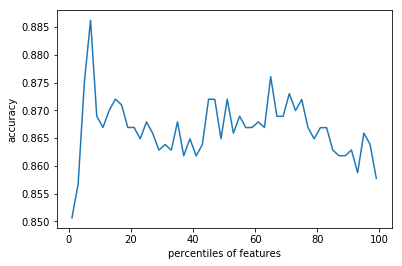

In [9]:
import pylab as pl
pl.plot(percentiles, results)
pl.xlabel('percentiles of features')
pl.ylabel('accuracy')
pl.show()


In [10]:
# 使用最佳筛选后的特征，利用相同配置的模型在测试集上进行性能评估。
from sklearn import feature_selection
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=7)
X_train_fs = fs.fit_transform(X_train, y_train)
dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
dt.score(X_test_fs, y_test)


0.8571428571428571